<a href="https://colab.research.google.com/github/ilombard20238/AIRetailScanner/blob/main/retail_ai_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
!pip install streamlit


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 46.1 MB/s eta 0:00:00


In [56]:
%%writefile app.py
# paste the Streamlit code here


Writing app.py


In [57]:
streamlit run app.py


SyntaxError: invalid syntax (ipython-input-507122745.py, line 1)

In [42]:
from google.colab import files
uploaded = files.upload()  # Select all images at once


Saving hairbrush.jfif to hairbrush.jfif
Saving suitcase.jfif to suitcase (1).jfif
Saving backpack.jfif to backpack.jfif
Saving notebook.avif to notebook.avif
Saving babybib.jfif to babybib.jfif
Saving shoes.jpg to shoes.jpg
Saving pastabox.png to pastabox.png
Saving whiteshirt.webp to whiteshirt.webp


In [43]:
import os
from pathlib import Path

# Create image folder
img_dir = Path("/content/retail_ai_demo/images")
img_dir.mkdir(parents=True, exist_ok=True)

# Move uploaded images into img_dir
uploaded_files = [
    "hairbrush.jfif",
    "suitcase.jfif",
    "backpack.jfif",
    "notebook.avif",  # optional, may skip
    "babybib.jfif",
    "shoes.jpg",
    "pastabox.png",
    "whiteshirt.webp"
]

for f in uploaded_files:
    src = Path(f)
    dst = img_dir / f
    if src.exists():
        os.rename(src, dst)


In [44]:
import pandas as pd

catalog_csv = """sku,name,category,original_price,current_price,is_set,image
2001,Hair Brush,Home,7.99,5.99,False,hairbrush.jfif
2002,Suitcase,Travel,59.99,49.99,False,suitcase.jfif
2003,Backpack,Travel,29.99,24.99,False,backpack.jfif
2004,Baby Bib,Baby,4.99,3.99,False,babybib.jfif
2005,Shoes,Clothing,49.99,39.99,False,shoes.jpg
2006,Pasta Box,Food,2.99,2.49,False,pastabox.png
2007,White Shirt,Clothing,19.99,14.99,False,whiteshirt.webp
"""

catalog_path = "/content/retail_ai_demo/catalog.csv"
with open(catalog_path, "w") as f:
    f.write(catalog_csv)

# Load catalog
catalog = pd.read_csv(catalog_path)
catalog


,sku,name,category,original_price,current_price,is_set,image
0,2001,Hair Brush,Home,7.99,5.99,False,hairbrush.jfif
1,2002,Suitcase,Travel,59.99,49.99,False,suitcase.jfif
2,2003,Backpack,Travel,29.99,24.99,False,backpack.jfif
3,2004,Baby Bib,Baby,4.99,3.99,False,babybib.jfif
4,2005,Shoes,Clothing,49.99,39.99,False,shoes.jpg
5,2006,Pasta Box,Food,2.99,2.49,False,pastabox.png
6,2007,White Shirt,Clothing,19.99,14.99,False,whiteshirt.webp


In [45]:
import torch
from torchvision import models, transforms
from PIL import Image
import numpy as np
from numpy.linalg import norm

# Load pretrained AlexNet
model = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)
model.eval()

# Transform for images
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

def get_features(img_path):
    img = Image.open(img_path).convert("RGB")
    img_t = transform(img).unsqueeze(0)
    with torch.no_grad():
        features = model.features(img_t)
        pooled = torch.nn.functional.adaptive_avg_pool2d(features,(1,1))
        return pooled.view(-1).numpy()

# Compute embeddings
catalog["embedding"] = catalog["image"].apply(lambda x: get_features(img_dir / x))


In [53]:
from google.colab import files

# Upload query image
print("Upload a product image to match:")
uploaded = files.upload()
query_path = list(uploaded.keys())[0]
query_embedding = get_features(query_path)

# Cosine similarity
def cosine_similarity(a,b):
    return np.dot(a,b)/(norm(a)*norm(b))

catalog["similarity"] = catalog["embedding"].apply(lambda e: cosine_similarity(e, query_embedding))
match = catalog.sort_values("similarity", ascending=False).iloc[0]

print("\n✅ Closest Match Found:")
print(f"Product: {match['name']}")
print(f"Category: {match['category']}")
print(f"Estimated Price: ${match['current_price']}")
print(f"Similarity Score: {match['similarity']:.3f}")


Upload a product image to match:


Saving Screenshot 2025-11-04 150408.png to Screenshot 2025-11-04 150408.png

✅ Closest Match Found:
Product: Hair Brush
Category: Home
Estimated Price: $5.99
Similarity Score: 0.397


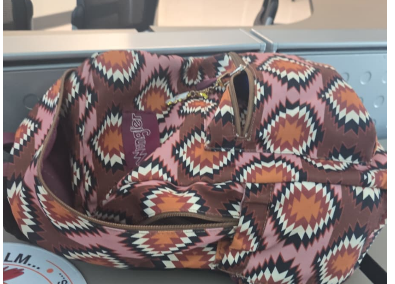

In [54]:
from IPython.display import display

img = Image.open(query_path)
display(img)
